In [36]:
%matplotlib inline
from __future__ import print_function
import argparse, gzip, cPickle, sys, time, itertools

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.norm as norm
import autograd.scipy.stats.dirichlet as dirichlet
from autograd.scipy.misc import logsumexp
from autograd.util import flatten_func, flatten
from autograd import grad, primitive
from autograd.numpy.numpy_grads import unbroadcast

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn import mixture

from  autograd.scipy.special import gammaln, digamma, gamma
from scipy import linalg
from scipy import stats, integrate

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
import pandas as pd
import six
from data import load_mnist

color_names =  ["windows blue",
               "red",
               "gold",
               "grass green",
               "orange", "yellow", "cornflower"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")

class Adam(object):
    def __init__(self, dparam, learning_rate = 1e-1, b1=0.9, b2=0.999, eps=10**-8,
                         decay_rate = 0.9, decay_steps = 100):                    
        self.b1 = b1;
        self.b2 = b2;
        self.eps = eps        
        self.m = np.zeros(dparam)
        self.v = np.zeros(dparam)
        self.learning_rate = learning_rate
        self.i = 0
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
    
    def update(self, gradients, params):        
        self.i = self.i+1
        step_size = self.learning_rate #* self.decay_rate**(self.i/self.decay_steps)        
        self.m = (1 - self.b1) * gradients + self.b1 * self.m
        self.v = (1 - self.b2) * (gradients**2) + self.b2 * self.v
        mhat = self.m / (1 - self.b1**(self.i))
        vhat = self.v / (1 - self.b2**(self.i))                        
        params = params + step_size*mhat/(np.sqrt(vhat) + self.eps)        
        return np.split(params,2)

    
@primitive
def softplus(x):
    return np.log(1. + np.exp(x))

softplus.defvjp(lambda g, ans, vs, gvs, x: unbroadcast(vs, gvs, g * 1./(1. + np.exp(-x))))

def jacobian_softplus(x):
    return 1./(1. + np.exp(-x))

relu = lambda x: np.maximum(x, 0.)
rbf = lambda x: np.exp(-x**2)
    
@primitive
def gamma_logpdf(x, alpha = 1., beta = 1.):
    return  (alpha*np.log(beta) + (alpha - 1)*np.log(x) - x*beta - gammaln(alpha))

gamma_logpdf.defvjp(lambda g, ans, vs, gvs, x, alpha=1.0, beta=1.0: unbroadcast(vs, gvs, g * ((alpha-1)/x - beta)))
gamma_logpdf.defvjp(lambda g, ans, vs, gvs, x, alpha=1.0, beta=1.0: unbroadcast(vs, gvs,  g * (np.log(beta) + np.log(x) - digamma(alpha))), argnum=1)
gamma_logpdf.defvjp(lambda g, ans, vs, gvs, x, alpha=1.0, beta=1.0: unbroadcast(vs, gvs,  g * (alpha/beta - x)), argnum=2)

In [37]:
def unpack_layers(weights):
        num_weight_sets = len(weights)
        for m, n in shapes:
            yield weights[:m*n]     .reshape((m, n)),\
                  weights[m*n:m*n+n].reshape((1, n))
            weights = weights[(m+1)*n:]
            
            
class BayesianNeuralNet(object):
    def __init__(self, data, test, scale = 1.):
        self.data = data     
        self.test = test        
        self.scale = scale
        self.noise_variance = 0.01
        self.N = data['x'].shape[0]        
        
    def predictions(self, weights, inputs):        
        for W, b in unpack_layers(weights):
            outputs = np.dot(inputs, W) + b
            inputs = rbf(outputs)                
        return outputs - logsumexp(outputs, axis=1, keepdims=True)            
    
#     def p_log_prob(self, idx, weights):
#         inputs, targets = self.data['x'][idx], self.data['y'][idx]
#         log_prior = np.sum(norm.logpdf(weights, 0., 1.))
#         log_lik = np.sum(self.predictions(weights, inputs) * targets)
#         return self.scale * log_lik + log_prior 

    def p_log_prob(self, idx, weights):
        inputs, targets = self.data['x'][idx], self.data['y'][idx]
        log_prior = -0.1 * np.sum(weights**2)
        preds = self.predictions(weights, inputs)
        log_lik = -np.sum((preds - targets)**2) / 0.01
        return log_prior + self.scale*log_lik

                                
    def q_log_prob(self, means, log_sigmas, z):
        q_w = np.sum(norm.logpdf(z, means, np.exp(log_sigmas)))        
        return q_w
      
    def q_log_prob_sep(self, means, log_sigmas, z):
        q_w = norm.logpdf(z, means, np.exp(log_sigmas))        
        return q_w
    
    def grad_params(self, dp_log_prob, eps, log_sigmas):                
        grad_means = dp_log_prob
        grad_log_sigmas = dp_log_prob*eps*np.exp(log_sigmas) + 1                
        return np.concatenate([grad_means, grad_log_sigmas])
        
    def accuracy(self, weights):        
        inputs, targets = self.test['x'], self.test['y']        
        log_prior = -0.1 * np.sum(weights**2)
        preds = self.predictions(weights, inputs)
        log_lik = -np.sum((preds - targets)**2) / 0.01
        return log_prior + log_lik

In [38]:
class Inference(object):      
    def __init__(self, model, params):
        self.model = model
        self.params = params

    def run(self, epochs, batch_size, samples, learning_rate, algorithm = 'SGD', optimizer = 'adam'):
        epochs = epochs
        batches = self.model.N/batch_size        
        batch_size = batch_size
        samples = samples
        learning_rate = learning_rate        
        
        means, unflatten = flatten(self.params['means'])
        log_sigmas, unflatten = flatten(self.params['log_sigmas'])        
        D =len(means)

        self.F = np.zeros(epochs * batches)
        self.accuracy = np.zeros(epochs * batches)
        self.time = np.zeros(epochs * batches)
        adam = Adam(2*D, learning_rate = learning_rate)
        f = 0
        
        grad_p_log_prob = grad(model.p_log_prob, argnum = 1)
        grad_q_log_prob = grad(model.q_log_prob, argnum = 1)    
        
        if algorithm == 'SGD':
            for e in range(epochs):
                for b in range(batches):                 
                    start = time.clock()
                    losses = 0.
                    d_elbo = 0.
                    idx = np.random.choice(np.arange(self.model.N), batch_size, replace=False)                    
                    for s in range(samples):
                        eps = npr.randn(D)        
                        z = np.exp(log_sigmas) * eps + means                           
                        p_log_prob = model.p_log_prob(idx, unflatten(z))                        
                        dp_log_prob, _ = flatten(grad_p_log_prob(idx, unflatten(z)))
                        g =  model.grad_params(dp_log_prob, eps, log_sigmas)                        
                        d_elbo += g
                        q_log_prob = model.q_log_prob(means, log_sigmas, z)                                         
                        losses +=  (p_log_prob - q_log_prob)                    
                    loss = losses/samples
                    d_elbo /= samples                       
                    means, log_sigmas = adam.update(d_elbo, np.concatenate([means, log_sigmas]))                    
                    self.F[f] =  -loss                
                    stop = time.clock()
                    self.time[f] = stop - start
                    self.accuracy[f] = model.accuracy(means)
                    f+=1                
                if e % 10 == 0:            
                    pstate = 'Epoch = ' + "{0:0=3d}".format(e) + ': Loss = {0:.3f}'.format(self.F[f-1]) + \
                        ': Test accuracy = {0:.3f}'.format(model.accuracy(means))                                        
                    print (pstate, end = '\r')
                    sys.stdout.flush()   
                else:
                    pstate = 'Epoch = ' + "{0:0=3d}".format(e) + ': Loss = {0:.3f}'.format(self.F[f-1])                        
                    print (pstate, end = '\r')
                    sys.stdout.flush()   
                    
                                         
        if algorithm == 'iSGD':
            n = 1.  
            z_old = [0.] * samples
            dp_log_prob_old = [0.] * samples
            q_log_prob_old = [0.] * samples                        
            for e in range(epochs):
                for b in range(batches): 
                    start = time.clock()
                    losses = 0.
                    d_elbo = 0.                    
                    if n > .7:
                        idx = np.random.choice(np.arange(self.model.N), batch_size, replace=False)                                        
                        for s in range(samples):
                            eps = npr.randn(D)        
                            z = np.exp(log_sigmas) * eps + means
                            p_log_prob = model.p_log_prob(idx, unflatten(z))
                            q_log_prob = model.q_log_prob_sep(means, log_sigmas, z)                                         
                            dp_log_prob, _ = flatten(grad_p_log_prob(idx, unflatten(z)))
                            g =  model.grad_params(dp_log_prob, eps, log_sigmas)                        
                            d_elbo += g
                            losses +=  (p_log_prob - np.sum(q_log_prob))
                                        
                            z_old[s] = z
                            dp_log_prob_old[s] = dp_log_prob
                            q_log_prob_old[s] = q_log_prob                          
                        loss = losses/samples
                        d_elbo /= samples       
                    else:
                        for s in range(samples):                                                        
                            eps = (z_old[s] - means)/np.exp(log_sigmas)                            
                            q_log_prob = model.q_log_prob_sep(means, log_sigmas, z_old[s])                                         
                            w = np.exp(q_log_prob - q_log_prob_old[s])                            
                            g =  model.grad_params(w * dp_log_prob_old[s], eps, log_sigmas)                        
                            d_elbo += g                              
                        d_elbo /= samples                           
                    n = npr.uniform()
                    means, log_sigmas = adam.update(d_elbo, np.concatenate([means, log_sigmas]))                    
                    self.F[f] =  -loss                
                    stop = time.clock()
                    self.time[f] = stop - start
                    self.accuracy[f] = model.accuracy(means)
                    f+=1                    
                if e % 10 == 0:       
                    pstate = 'Epoch = ' + "{0:0=3d}".format(e) + ': Loss = {0:.3f}'.format(self.F[f-1]) + \
                        ': Test accuracy = {0:.3f}'.format(model.accuracy(means))                                            
                    print (pstate, end = '\r')
                    sys.stdout.flush()  
                else:
                    pstate = 'Epoch = ' + "{0:0=3d}".format(e) + ': Loss = {0:.3f}'.format(self.F[f-1])                        
                    print (pstate, end = '\r')
                    sys.stdout.flush()   
        self.params = {'means': unflatten(means), 'log_sigmas': unflatten(log_sigmas)}

In [33]:
layer_sizes = [784, 200, 10]
L2_reg = 1.0
shapes = list(zip(layer_sizes[:-1], layer_sizes[1:]))
num_weights = sum((m+1)*n for m, n in shapes)

# Training parameters
param_scale = 0.1
batch_size = 256
num_epochs = 5
step_size = 0.001

#N, train_images, train_labels, test_images, test_labels = load_mnist()
N = 10000
data, test = {},{}
data['x'] = train_images[:N]
data['y'] = train_labels[:N]
test['x'] = test_images[:1000]
test['y'] = test_labels[:1000]

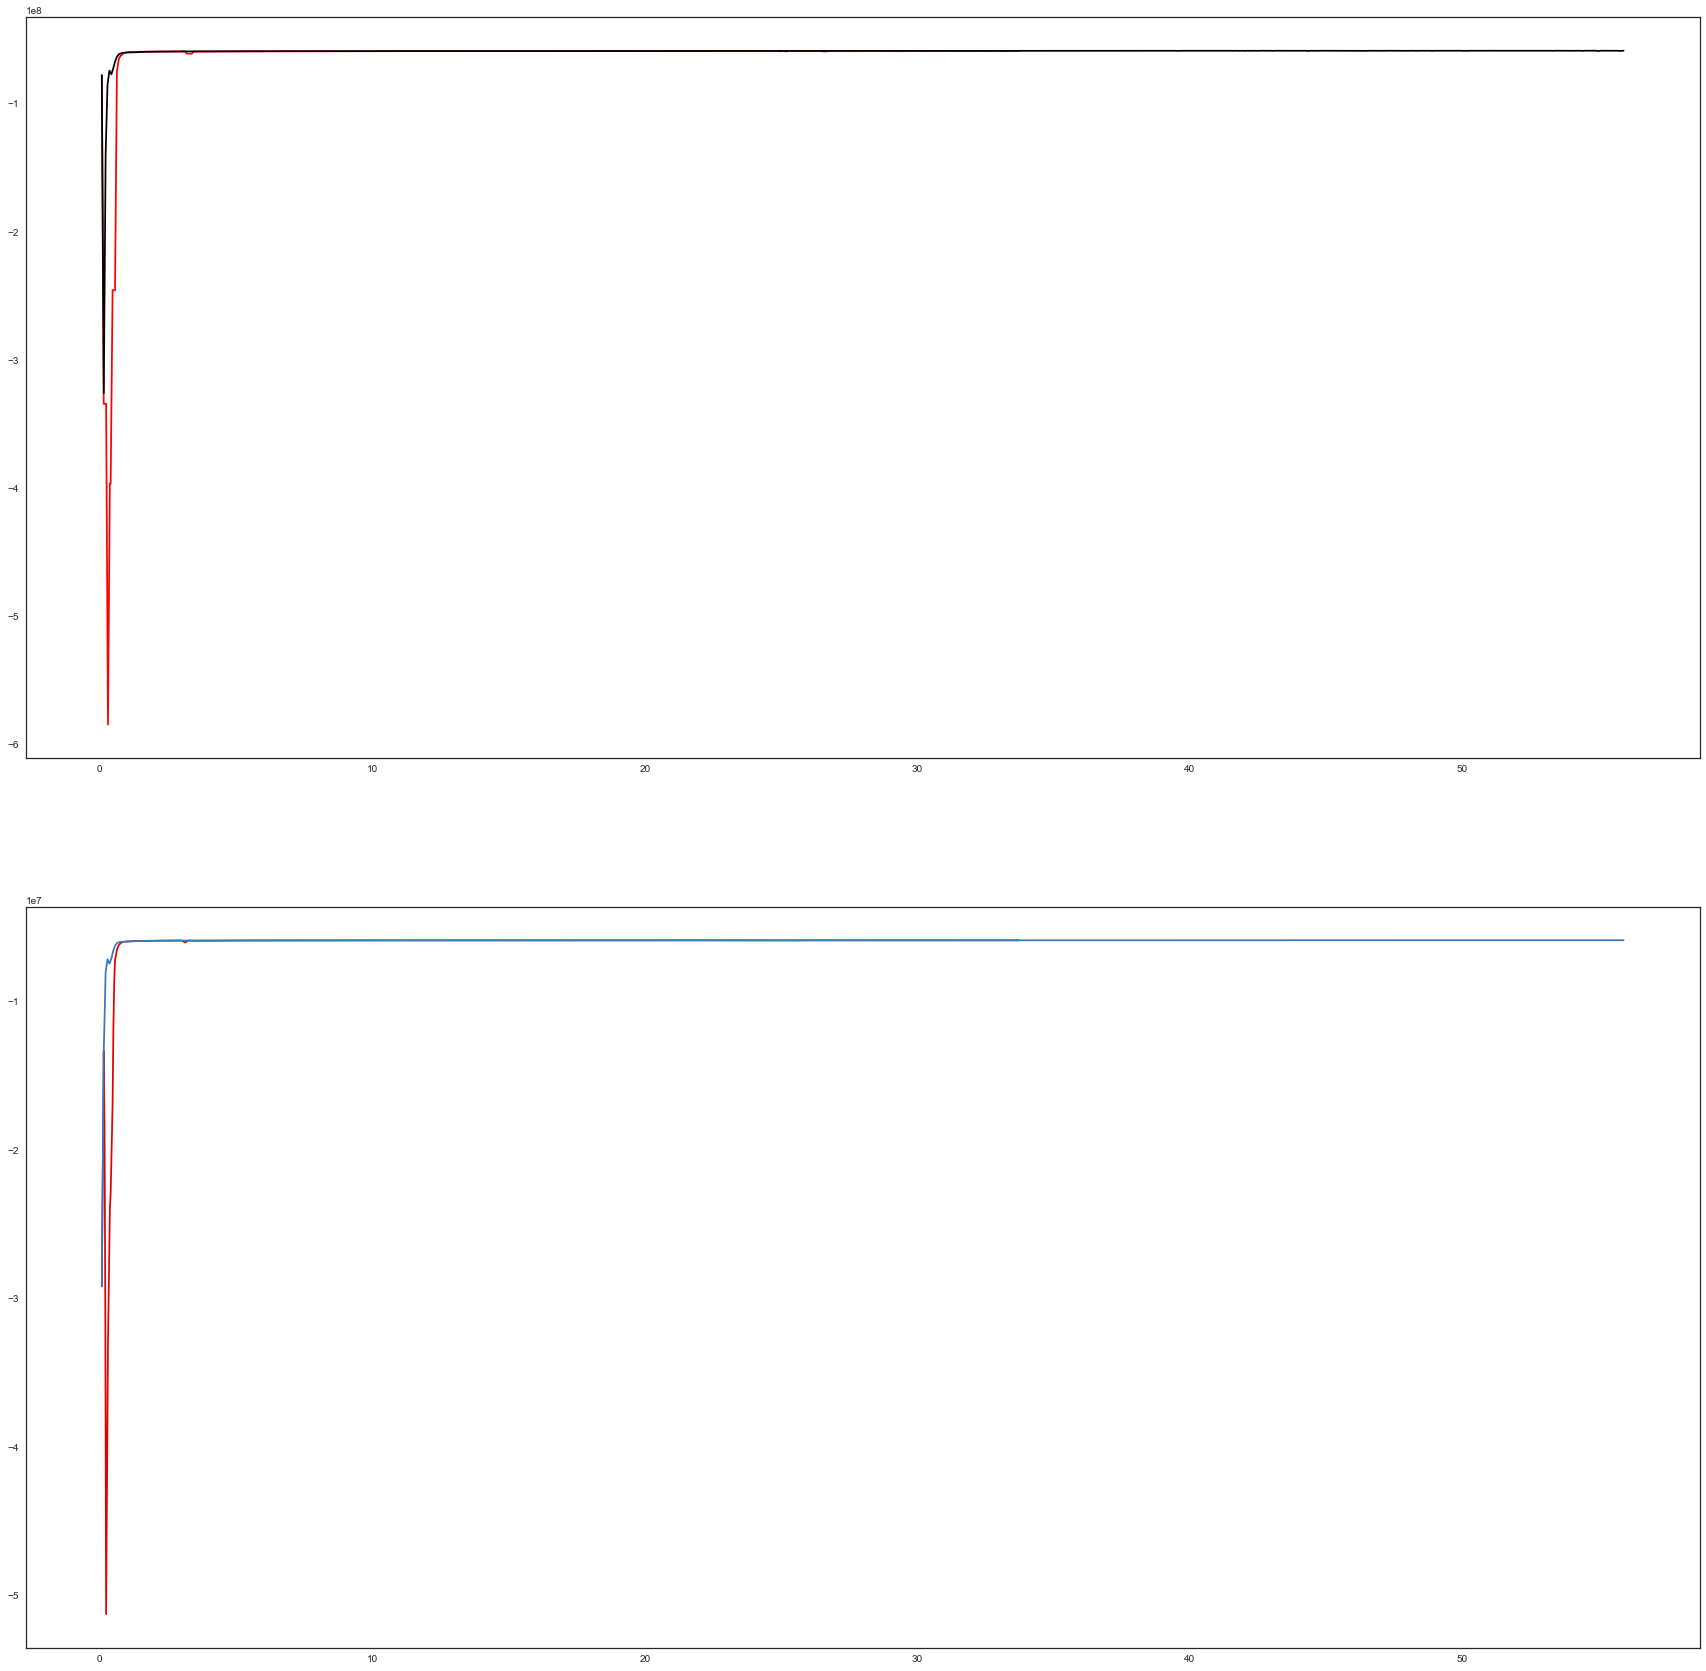

In [34]:
epochs = 20
samples = 1
batch_size = 256
learning_rate = 0.01
seed = 111
model = BayesianNeuralNet(data, test, N/batch_size)
f, (ax1, ax2) = plt.subplots(2,1,figsize=(30,30))

npr.seed(seed)
params = {}
params['means']  = 0.1 * npr.randn(num_weights)
params['log_sigmas'] = -5 * np.ones(num_weights)
inference = Inference(model, params)
inference.run(epochs, batch_size, samples, learning_rate, 'iSGD')
ax1.plot(np.cumsum(inference.time), -inference.F, color = 'r')
ax2.plot(np.cumsum(inference.time), inference.accuracy, color = colors[1])

npr.seed(seed)
params = {}
params['means']  = 0.1 * npr.randn(num_weights)
params['log_sigmas'] = -5 * np.ones(num_weights)
inference = Inference(model, params)
inference.run(epochs, batch_size, samples, learning_rate, 'SGD')
ax1.plot(np.cumsum(inference.time), -inference.F, color = 'k')
ax2.plot(np.cumsum(inference.time), inference.accuracy, color = colors[0])

In [35]:
def build_toy_dataset(n_data=40, noise_std=0.1):
    D = 1
    rs = npr.RandomState(0)
    inputs  = np.concatenate([np.linspace(0, 2, num=n_data/2),
                              np.linspace(6, 8, num=n_data/2)])
    targets = np.cos(inputs) + rs.randn(n_data) * noise_std
    inputs = (inputs - 4.0) / 4.0
    inputs  = inputs.reshape((len(inputs), D))
    targets = targets.reshape((len(targets), D))
    return inputs, targets

ValueError: shapes (400,) and (1,20) not aligned: 400 (dim 0) != 1 (dim 0)

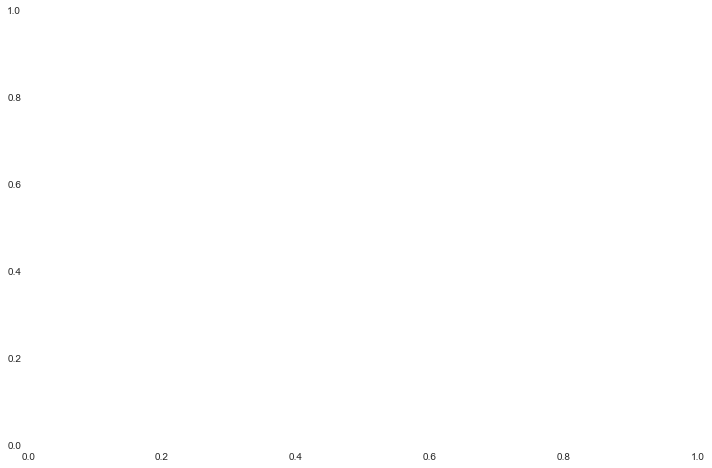

In [46]:
fig = plt.figure(figsize=(12, 8), facecolor='white')
ax = fig.add_subplot(111, frameon=False)
def callback(mean, log_std,model):    
    # Sample functions from posterior.
    rs = npr.RandomState(0)    
    #rs = npr.RandomState(0)
    sample_weights = rs.randn(num_weights) * np.exp(log_std) + mean
    plot_inputs = np.linspace(-8, 8, num=400)
    outputs = model.predictions(sample_weights, plot_inputs)

    # Plot data and functions.
    plt.cla()
    ax.plot(model.data['x'].ravel(), model.data['y'].ravel(), 'bx')
    ax.plot(plot_inputs, outputs[:, :, 0].T)
    ax.set_ylim([-2, 3])    
    plt.draw()

layer_sizes = [1, 20, 20, 1]
shapes = list(zip(layer_sizes[:-1], layer_sizes[1:]))
num_weights = sum((m+1)*n for m, n in shapes)
        
inputs, targets = build_toy_dataset()
data = {}
data['x'] = inputs
data['y'] = targets

epochs = 20
samples = 1
batch_size = 40
learning_rate = 0.01
seed = 111
model = BayesianNeuralNet(data, data, 1.)

npr.seed(seed)
params = {}
params['means']  = 0.1 * npr.randn(num_weights)
params['log_sigmas'] = -5 * np.ones(num_weights)
callback(params['means'], params['log_sigmas'], model)
# inference = Inference(model, params)

In [42]:
num_weights

481